# Cleaning and Imputation

---


## Imports and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from matplotlib.lines import Line2D

import random

In [2]:
def clean_col(col_name):
    '''
    Rename column label to be more Pythonic:
    - lowercase
    - underscore between words
    - replace some language with more descriptive words
    
    Return revised column name.
    '''
    col_name = col_name.lower()
    col_name = col_name.replace('pct','_pct')
    col_name = col_name.replace('state','st')
    col_name = col_name.replace('acstot','')
    col_name = col_name.replace('minor','poc')
    col_name = col_name.replace('less','sub_')
    col_name = col_name.replace('lowinc','low_inc')
    col_name = col_name.replace('ling','ling_')
    col_name = col_name.replace('under5','under_5')
    col_name = col_name.replace('over64','over_64')
    col_name = col_name.replace('vuleo_pct','dem_index')
    col_name = col_name.replace('pre1960','pre_1960')
    col_name = col_name.replace('ptraf','traffic_prox')
    col_name = col_name.replace('dslpm','diesel_pm')
    col_name = col_name.replace('pnpl','npl_prox')
    col_name = col_name.replace('prmp','rmp_prox')
    col_name = col_name.replace('ptsdf','waste_prox')
    col_name = col_name.replace('resp','resp_index')
    col_name = col_name.replace('pwdis','waste_water')
    col_name = col_name.replace('25','_25')
    col_name = col_name.replace('ust','undgrd_stor')
    
    return col_name

In [3]:
np.random.seed(13)

---
## Cleaning

#### Renaming columns

In [4]:
raw_data = pd.read_csv('../data/EJSCREEN_2021_StatePctile_Tracts.csv')

C:\Users\John\AppData\Local\Temp\ipykernel_20620\1401447621.py:1: DtypeWarning: Columns (128,129,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('../data/EJSCREEN_2021_StatePctile_Tracts.csv')


Columns beginning with `B_` and `T_` provide information for creating specialized images. This is not necessary for our exploratory data analysis so we will drop these columns. Columns beginning with `P_` and `D_` contain percentile and index data. These can be reconstructed from other columns without much difficulty, so we will drop these as well.

There is also identification data in the first two columns that we do not need for data analysis. We will drop these columns, too.

In [5]:
# initial columns of interest
# cut columns related to image data, clean the rest
init_cols = [col for col in raw_data.columns if col[:2] not in 'P_B_T_D_']

# drop OBJECTID - repeated index col
init_cols = init_cols[2:]
init_cols

['STATE_NAME',
 'ST_ABBREV',
 'REGION',
 'ACSTOTPOP',
 'MINORPCT',
 'LOWINCPCT',
 'LESSHSPCT',
 'LINGISOPCT',
 'UNDER5PCT',
 'OVER64PCT',
 'UNEMPPCT',
 'VULEOPCT',
 'PRE1960PCT',
 'DSLPM',
 'CANCER',
 'RESP',
 'PTRAF',
 'PWDIS',
 'PNPL',
 'PRMP',
 'PTSDF',
 'OZONE',
 'PM25',
 'UST',
 'Shape_Length',
 'Shape_Area']

Below use our `clean_col` function to rename the column labels to be more clear and Pythonic (replace spaces with underscores, use more descriptive language, and put the letters in lowercase form).

In [6]:
env = raw_data[init_cols].copy()
env.columns = [clean_col(col) for col in env.columns]

To check the results, we list out the revised column names.

In [7]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'dem_index', 'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index',
       'traffic_prox', 'waste_water', 'npl_prox', 'rmp_prox', 'waste_prox',
       'ozone', 'pm_25', 'undgrd_stor', 'shape_length', 'shape_area'],
      dtype='object')

#### Removing Empty Rows

There are few hundred rows of data where the numeric entries consist entirely of zeros or missing values. These rows will be impossible to work with and should be removed.

In [8]:
# drop rows containing no information (consisting of ALL zeros and nulls)

# identify location of first and last numeric columns
pop_index = env.columns.get_loc('pop')
stor_index = env.columns.get_loc('undgrd_stor')

# count nulls within a row
nulls_in_row = env.iloc[:,pop_index:stor_index+1].isnull().sum(axis = 1)
# count zeros within a row
zeros_in_row = (env.iloc[:,pop_index:stor_index+1] == 0).sum(axis = 1)

# if zeros and nulls sum to number of numeric columns, drop the row
total_num_cols = env.iloc[:,pop_index:stor_index+1].shape[1]
env.drop(index = env[nulls_in_row + zeros_in_row == total_num_cols].index, inplace = True)

#### Dropping Missing Cancer Data

One of our major goals is to predict the air toxics cancer risk given by the `cancer` column. Since this column is especially valuable to us, we want to avoid imputing missing values within it. Below we see it contains 246 missing values.

In [9]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm         246
cancer            246
resp_index        246
traffic_prox     2343
waste_water     19644
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
shape_length        0
shape_area          0
dtype: int64

Before we drop the rows missing `cancer` data, we must check to see if the entries seem genuinely random and that we are not introducing any blatant bias to our dataset.

In [10]:
# rows missing cancer data
na_cancer = env.loc[env['cancer'].isna()]

print(f'There are {na_cancer.shape[0]} rows with missing cancer rates data.')
print(f"There are {(na_cancer['pop'] == 0).sum()} rows with missing cancer rates data and population data.")

There are 246 rows with missing cancer rates data.
There are 231 rows with missing cancer rates data and population data.


Above we see that nearly all of the rows missing cancer data also have a population of zero. In fact, these rows missing cancer values almost all have numerous values zeros (shown below). It seems reasonable to drop all 246 of these rows.

In [11]:
na_cancer.describe()

,region,pop,poc_pct,low_inc_pct,sub_hs_pct,ling_iso_pct,under_5_pct,over_64_pct,unemp_pct,dem_index,...,traffic_prox,waste_water,npl_prox,rmp_prox,waste_prox,ozone,pm_25,undgrd_stor,shape_length,shape_area
count,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,...,6.000000,3.000000e+00,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,246.000000,2.460000e+02
mean,4.910569,43.890244,0.042488,0.021509,0.008462,0.000606,0.002056,0.008651,0.008465,0.031998,...,1664.390494,1.673835e-06,0.002365,0.018999,0.063761,41.701752,8.337682,0.064098,55041.854449,2.782879e+08
std,2.410887,321.187567,0.181458,0.136748,0.052922,0.009503,0.018557,0.070131,0.077078,0.139287,...,4039.846715,1.733399e-06,0.021045,0.143617,0.633274,7.298773,1.523231,0.532157,92903.832197,1.268873e+09
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.128077,5.716715e-07,0.000000,0.000000,0.000000,26.797583,4.282411,0.000000,1797.428238,1.313539e+05
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.885549,6.748299e-07,0.000000,0.000000,0.000000,37.400371,7.345422,0.000000,11189.223043,4.923604e+06
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,8.390268,7.779884e-07,0.000000,0.000000,0.000000,41.667395,8.346472,0.000000,18972.747032,1.301009e+07
75%,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,42.436614,2.224916e-06,0.000000,0.000000,0.000000,44.712277,9.139091,0.000000,62662.813232,1.237268e+08
max,10.000000,4291.000000,1.000000,1.000000,0.420664,0.149051,0.241667,0.903061,1.000000,1.000000,...,9910.598316,3.671844e-06,0.239815,1.371522,9.362956,73.565369,13.042804,6.636750,722509.794497,1.718428e+10


We can also see that these rows are relatively evenly distributed across the different states, so we are not singling any stat out by dropping these rows.

In [12]:
na_cancer['st_name'].value_counts()

New York          31
Florida           26
California        18
Texas             16
Michigan          13
Virginia          12
Louisiana         12
North Carolina    10
Tennessee          8
Colorado           7
Pennsylvania       7
Georgia            7
Nevada             7
South Carolina     6
Illinois           6
Arizona            6
Massachusetts      5
Kentucky           5
Mississippi        4
Maryland           4
Kansas             4
New Hampshire      3
Utah               3
Ohio               3
Oregon             3
Washington         3
Wisconsin          3
New Jersey         2
Iowa               2
Missouri           2
Vermont            1
Alabama            1
New Mexico         1
Minnesota          1
Indiana            1
Delaware           1
Connecticut        1
Wyoming            1
Name: st_name, dtype: int64

In [13]:
env.dropna(subset = ['cancer'], inplace = True)

Conveniently, dropping the rows with missing `cancer` values also dealth with all of the missing `diesel_pm` and `resp_index` values..

In [14]:
env.isnull().sum()

st_name             0
st_abbrev           0
region              0
pop                 0
poc_pct             0
low_inc_pct         0
sub_hs_pct          0
ling_iso_pct        0
under_5_pct         0
over_64_pct         0
unemp_pct           0
dem_index           0
pre_1960_pct        0
diesel_pm           0
cancer              0
resp_index          0
traffic_prox     2103
waste_water     19401
npl_prox            0
rmp_prox            0
waste_prox          0
ozone            1383
pm_25            1383
undgrd_stor         0
shape_length        0
shape_area          0
dtype: int64

#### Removing `waste_water` and `dem_index`

Above we see there is a heavy density of null values remaining in the `waste_water` column. In addition to this, our target `cancer` column is defined in terms of air toxic cancer risk. Because this column seems like difficult to salvage and it is not immediately related to our target, we will drop it from our dataset.

Another column that we will drop is `dem_index` as it is simply the product of the `poc_pct` and `low_inc_pct` columns.

In [15]:
env.drop(columns = ['waste_water', 'dem_index'], inplace = True)

#### Puerto Rico, Hawaii, and Alaska

It would be convenient if we could drop the remaning null values from our dataset since they represent a fairly small fraction of our dataset.

In [16]:
env.shape

(73420, 24)

Unfortunately, the remaining null values (specifically `ozone` and `pm_25`) are not completely random and dropping these null values would completely eliminate Puerto Rico, Hawaii, and Alaska from our dataset.

Below we look at the top 10 state appearances across all of the rows containing null values. When we compare this to the state appearances across all rows (with and without null values), we see the counts between the two groups agree for Puerto Rico, Hawaii, and Alaska. In other words, blindly dropping the null values would drop all of the data for these states and territories. 

In [17]:
# collect rows where there are any missing values

# na_rows are the incdices of null values
na_rows = env.select_dtypes(include = 'number').isna().any(axis = 1)

# has_na is the dataset containing null
has_na = env[na_rows]

In [18]:
# 10 states with the most null values in the dataset currently
null_states = has_na['st_abbrev'].value_counts().head(10)
null_states

PR    895
HI    321
AK    167
KY    122
TX    122
MI    118
NC    106
OH     86
NY     81
ME     79
Name: st_abbrev, dtype: int64

In [19]:
# the total number of appearances of these states in the entire dataset
env['st_abbrev'].value_counts()[null_states.index]

PR     895
HI     321
AK     167
KY    1110
TX    5238
MI    2756
NC    2174
OH    2943
NY    4870
ME     351
Name: st_abbrev, dtype: int64

Another thing to note about these three groups is that their nulls are almost exclusively located in in the `ozone` and `pm_25` columns.

In [20]:
# print out the number of null values in each column for PR, HI, and AK
for territory in ['PR', 'HI', 'AK']:
    print(territory)
    print(env[env['st_abbrev'] == territory].isnull().sum(), '\n\n')

PR
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox      7
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           895
pm_25           895
undgrd_stor       0
shape_length      0
shape_area        0
dtype: int64 


HI
st_name           0
st_abbrev         0
region            0
pop               0
poc_pct           0
low_inc_pct       0
sub_hs_pct        0
ling_iso_pct      0
under_5_pct       0
over_64_pct       0
unemp_pct         0
pre_1960_pct      0
diesel_pm         0
cancer            0
resp_index        0
traffic_prox     10
npl_prox          0
rmp_prox          0
waste_prox        0
ozone           321
pm_25           321
undgrd_stor       0
shape_length      0
shape_area        0
dtype: int64 


AK

#### Percentages and Population Size

Something else to be cautious of is that several columns are based on percentages of the population. These percentages can be somewhat deceptive for rows containing lower populations. For example, 100% of the population being minority feels more meaningful when the population size is 2416 than if the population size is 8. For this reason we want to remove rows with especially small population sizes.

Additionally, each row represents a Census tract. Census tracts generally have a population size above 1,200. Rows with a population size below 1,200 correspond to tribal data. We do not want to eliminate the tribal data, especially with the history of environmental injustice towards indigenous people. For this reason, we will set a population size of 30 as a lower bound for the data. This way, we can feel more confident in interpreting percentages and still keep as much of the tribal data as possible.

Below we verify that the data corresponding to population sizes below 30 is reasonably distributed across all states.

In [21]:
env.loc[env['pop'] <= 30, 'st_name'].value_counts()

New York          34
Florida           19
California        18
Texas             15
Pennsylvania      15
Puerto Rico       10
Virginia          10
Tennessee          9
Hawaii             8
Kansas             6
Michigan           6
North Carolina     5
Massachusetts      4
Missouri           4
Louisiana          4
Arizona            4
Ohio               3
Alabama            3
Kentucky           3
Maryland           2
New Jersey         2
Indiana            2
Georgia            2
Rhode Island       1
Washington         1
Arkansas           1
South Carolina     1
Montana            1
Idaho              1
Nebraska           1
Oklahoma           1
Alaska             1
Illinois           1
Nevada             1
Oregon             1
Name: st_name, dtype: int64

In [22]:
env = env[env['pop']>=30]

#### Removing Rows with Too Many Zeros

Earlier when we examined rows with a population size of zero, we saw that many of them also had zeros in other demographic columns. The demographic columns are primarily percentages, so values of zero within these columns are possible but highly unlikely (especially in places with large populations). It is likely the case that some of the zeros are really just missing values.

Below we show the Census tracts containing six values of zero. Notice that the first California tract a population of 6,372. It is hard to imagine that there are no unemployed or elderly people.

In [23]:
# subset the data along the demographic columns
dem_info = env.loc[:,'pop':'unemp_pct']

In [24]:
env[(dem_info == 0).sum(axis = 1) == 6].sort_values(by = 'pop', ascending = False).head(10).T

,9303,27390,12257,48572,45064,48574,29408,48676,18616,69328
st_name,California,Kentucky,Colorado,North Carolina,New York,North Carolina,Louisiana,North Carolina,Georgia,Virginia
st_abbrev,CA,KY,CO,NC,NY,NC,LA,NC,GA,VA
region,9,4,8,4,2,4,6,4,4,3
pop,6372,4641,4329,3801,2969,2697,1918,1727,737,686
poc_pct,0.537665,0.382892,0.236082,0.416206,0.134725,0.342974,0.513034,0.525767,0.489824,0.629738
low_inc_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sub_hs_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ling_iso_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
under_5_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
over_64_pct,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Unfortunately, because we cannot accurately determine when these zeros are genuine zeros or missing values, we do not have a great way to correct this problem. Our approach will be to simply remove rows with too many zeros in the demographic columns.

Looking at the value counts of the number of zeros that appear in each row, it seems safe to remove all of the rows containing five or more zeros.

In [25]:
# sum the number of zeros in each row
# then determine the appearances of each coun
(dem_info == 0).sum(axis = 1).value_counts(ascending = True).sort_index(ascending = False)

7        1
6       27
5       57
4      131
3       96
2      495
1    18658
0    53755
dtype: int64

In [26]:
# remove rows with 5 or more zeros
env = env[(dem_info == 0).sum(axis = 1) < 5]

#### Cancer Outlier

There is one major outlier in the cancer column containing a value of 2,000.

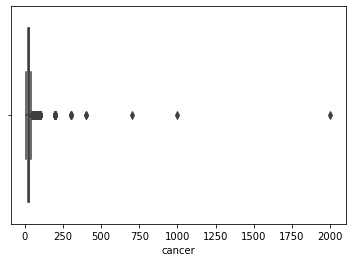

In [27]:
sns.boxplot(x = env['cancer']);

This outlier comes from a Census tract in Puerto Rico with high POC and low income percentages, but otherwise typical values in the other columns. After further research, we were unable to find any indication that areas in Puerto Rico have extremely high instances of cancer, and therefore it is possible that this observation is an error.

The next largest cancer rate we see in the data is a value of 1,000 that comes from a Census tract in Louisiana. There is an infamous area there known as ‘Cancer Alley’ with extraordinarily high cancer rates. Therefore this observation may be reasonable to leave in our dataset.

In [28]:
# drop the cancer 
env = env[env['cancer'] < 1500]

We will now save this DataFrame to a csv file for future reference.

In [29]:
env.to_csv('../data/cleaned_ejscreen.csv', index = True)

---

## Imputing

#### Transforming the Data

We have dealt with all of the null values except for those in the `traffic_prox`, `ozone`, and `pm_25` columns. Let us now resort to imputing these missing values in all three columns using iterative imputer

In [30]:
cols_to_impute = ['traffic_prox', 'ozone', 'pm_25']

In [31]:
env.columns

Index(['st_name', 'st_abbrev', 'region', 'pop', 'poc_pct', 'low_inc_pct',
       'sub_hs_pct', 'ling_iso_pct', 'under_5_pct', 'over_64_pct', 'unemp_pct',
       'pre_1960_pct', 'diesel_pm', 'cancer', 'resp_index', 'traffic_prox',
       'npl_prox', 'rmp_prox', 'waste_prox', 'ozone', 'pm_25', 'undgrd_stor',
       'shape_length', 'shape_area'],
      dtype='object')

We will use a linear regression for our imputation, so let us begin by dropping some columns that seem irrelevant for the columns with missing data. We will also drop the cancer column to avoid data leakage.

In [32]:
X = env.drop(columns = ['cancer', 'st_name', 'st_abbrev', 'shape_length', 'shape_area'])
y = env['cancer']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 13)

Our regions data is categorical despite have numeric values. Before running the iterative imputer, let us one hot encode the `region` column.

In [33]:
# instantiate our transformers:

# one-hot encoder for the region column
ohe = OneHotEncoder(drop='first'), ['region']

# column transformer for apply ohe to only the region column
ct = make_column_transformer(ohe, remainder = 'passthrough')

# use linear regression for imputation
it = IterativeImputer(estimator = LinearRegression())

In [34]:
# one-hot encode the region column (with column transformer) in both our train and validation set
X_train_ohe = ct.fit_transform(X_train)
X_val_ohe = ct.transform(X_val)

# apply iterative imputer to our train and validation data (after one-hot encoding)
X_train_imputed = it.fit_transform(X_train_ohe)
X_val_imputed = it.transform(X_val_ohe)

#### Saving the Imputed Results to csv

We will also convert our training and validation data to DataFrames to save them as csv files now that they are imputed. This will allow us to access this data more easily across different notebooks. In case we care to refer back to this information we will preserve the indices, state information, and tract shape.

In [35]:
# convert our train and validation X data to DataFrames (preserving indices)
X_train_df = pd.DataFrame(X_train_imputed, columns = ct.get_feature_names_out(), index = y_train.index)
X_val_df = pd.DataFrame(X_val_imputed, columns = ct.get_feature_names_out(), index = y_val.index)

In [36]:
# include y cancer column, state information, and tract shape
train_imputed = X_train_df.merge(right = env[['cancer', 'st_name', 'st_abbrev', 'shape_length', 'shape_area']],
                                how = 'left',
                                left_index = True,
                                right_index = True).sort_index()

# include y cancer column, state information, and tract shape
val_imputed = X_val_df.merge(right = env[['cancer', 'st_name', 'st_abbrev', 'shape_length', 'shape_area']],
                                how = 'left',
                                left_index = True,
                                right_index = True).sort_index()

Since the data has been one-hot encoded on a specific column, the columns have been relabeled. Let us revert the columns back to their original form.

In [37]:
# illustrate column names are different than how they started
train_imputed.columns

Index(['onehotencoder__region_2', 'onehotencoder__region_3',
       'onehotencoder__region_4', 'onehotencoder__region_5',
       'onehotencoder__region_6', 'onehotencoder__region_7',
       'onehotencoder__region_8', 'onehotencoder__region_9',
       'onehotencoder__region_10', 'remainder__pop', 'remainder__poc_pct',
       'remainder__low_inc_pct', 'remainder__sub_hs_pct',
       'remainder__ling_iso_pct', 'remainder__under_5_pct',
       'remainder__over_64_pct', 'remainder__unemp_pct',
       'remainder__pre_1960_pct', 'remainder__diesel_pm',
       'remainder__resp_index', 'remainder__traffic_prox',
       'remainder__npl_prox', 'remainder__rmp_prox', 'remainder__waste_prox',
       'remainder__ozone', 'remainder__pm_25', 'remainder__undgrd_stor',
       'cancer', 'st_name', 'st_abbrev', 'shape_length', 'shape_area'],
      dtype='object')

In [38]:
# create new labels without 'onehotencoder__' or 'remainder__' prefix
new_col_labels = [col.replace('onehotencoder__', '').replace('remainder__', '') for col in train_imputed.columns]

# convert column labels in both train and validation sets
train_imputed.columns = new_col_labels
val_imputed.columns = new_col_labels

Finally, we are ready to save our data to csv files.

In [39]:
# save data as csv files
# preserve index
train_imputed.to_csv('../data/train_cleaned_imputed.csv', index = True)
val_imputed.to_csv('../data/val_cleaned_imputed.csv', index = True)

#### Comparing Data With and Without Imputation

As a final check for our imputation, we will compare the distributions of `traffic_prox`, `ozone`, and `pm_25` to their distributions before imputation. Since we are not doing any modeling yet, we will look at the training and testing data together.

In [40]:
env_imputed = pd.concat([train_imputed, val_imputed]).sort_index()

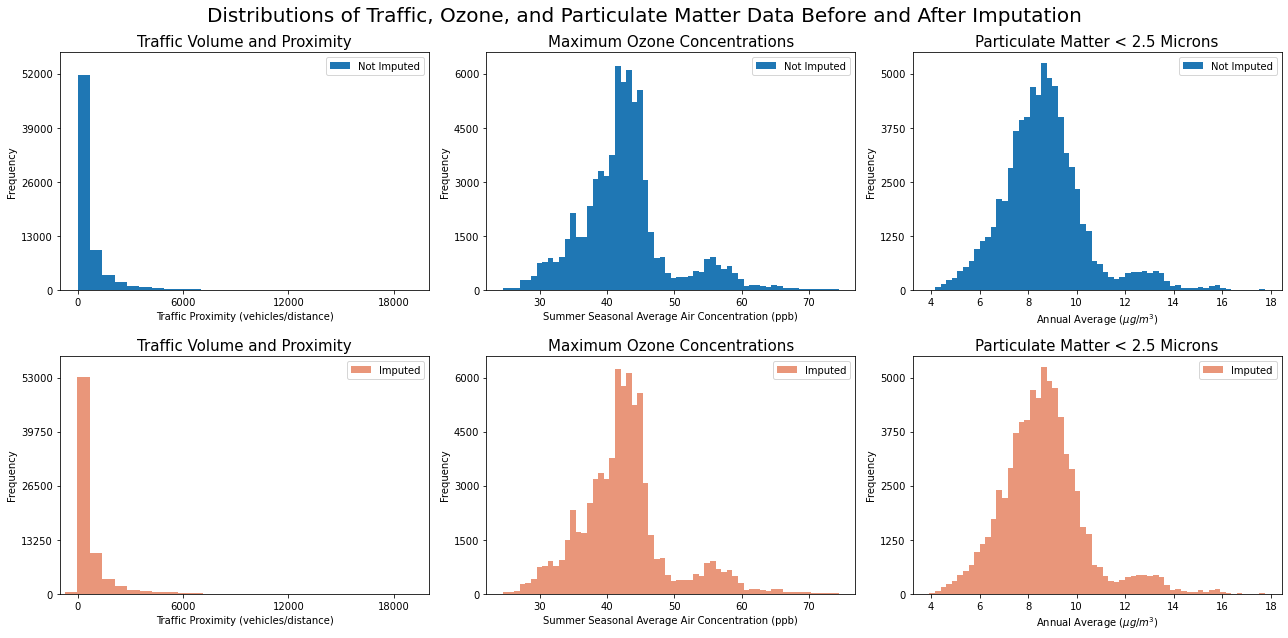

In [41]:
# plot 2x3 grid of histograms of the data 
# not imputed distributions on top, imputed distributions on bottom

plt.figure(figsize = (18, 9))

i = 1

# figure title
plt.suptitle('Distributions of Traffic, Ozone, and Particulate Matter Data Before and After Imputation', size = 20)


# titles for the three different columns
title_dict = {'traffic_prox': 'Traffic Volume and Proximity',
             'ozone': 'Maximum Ozone Concentrations',
             'pm_25': 'Particulate Matter < 2.5 Microns'}

# x labels for the three different columns
x_labels = {'traffic_prox': 'Traffic Proximity (vehicles/distance)',
           'ozone': 'Summer Seasonal Average Air Concentration (ppb)',
           'pm_25': 'Annual Average ($\mu g/m^3$)'}

# iterate over the six columns and plot their histograms
for df in [env, env_imputed]:
    for col in cols_to_impute:
        
        # choose color and legend label based on whether the data is env or env_imputed
        # using the first column label to determine
        hist_color = 'darksalmon'
        label = 'Imputed'
        
        # if first column label matches the environmental dataframe
        # change color and label
        if df.columns[0] == 'st_name':
            hist_color = 'tab:blue'
            label = 'Not Imputed'
        
        # generate subplot with title and axis labels
        plt.subplot(2,3,i)
        plt.title(f'{title_dict[col]}', size = 15)
        plt.xlabel(x_labels[col])
        plt.ylabel('Frequency')
        
        # plot distribution and legend
        plt.hist(df[col], color = hist_color, bins = 60, label = label)
        plt.legend()
        
        # adjust horizontal axis on traffic proximity
        if col == 'traffic_prox':
            plt.xlim([-1_000, 20_000])
            plt.xticks([6000 * i for i in range(4)])
            
        # adjust vertical axis according to the largest value_counts data
        largest_bin_count = df[col].value_counts(bins = 60).iloc[0]
        
        # round largest_value counts to the nearest thousand
        y_lim = round(largest_bin_count, -3)

        # only use 4 tick marks along the y-axis
        plt.ylim([0, 1.1*y_lim])
        plt.yticks([0, y_lim* (1/4), y_lim * (2/4), y_lim * (3/4), y_lim])
        
        # move on to next subplot
        i += 1
        
# adjust subplot spacing
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.875,
                    wspace=0.3,
                    hspace=0.5)

plt.tight_layout()
plt.savefig('../images/impute_distributions.png')

We see that the distributions are nearly identical the between the two groups (not imputed and imputed).